findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


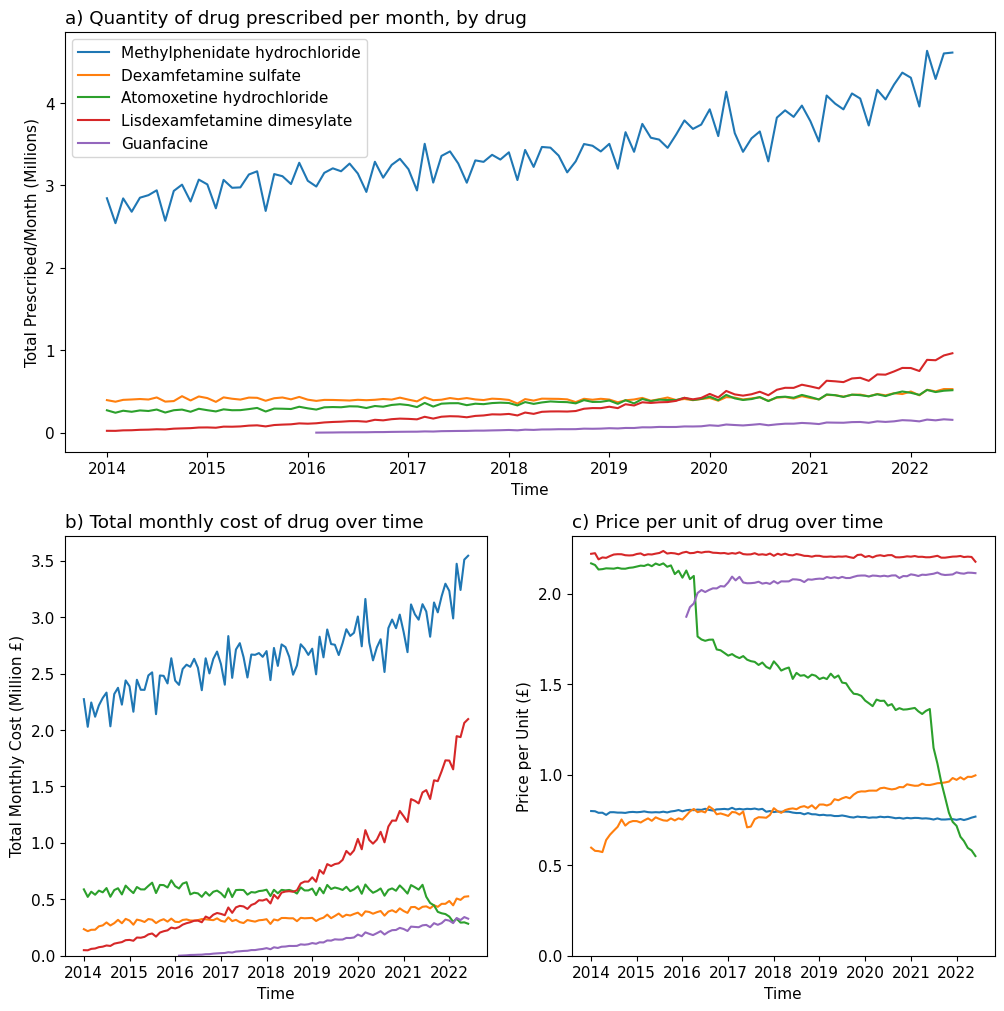

1000.8777742938253
950.9788144869763
888.2327348858574
767.2283743032614
853.9837830890534
1506.6900575068287
697.6277851605568
2443.9054681073285
4996.394479081477
Coefficient pre-COVID-19: 703.7
Coefficient post-COVID-19: 1991.0
Projected quantity/month in 2025: 8356760
Projected quantity/month in 2025 (old model): 6211883


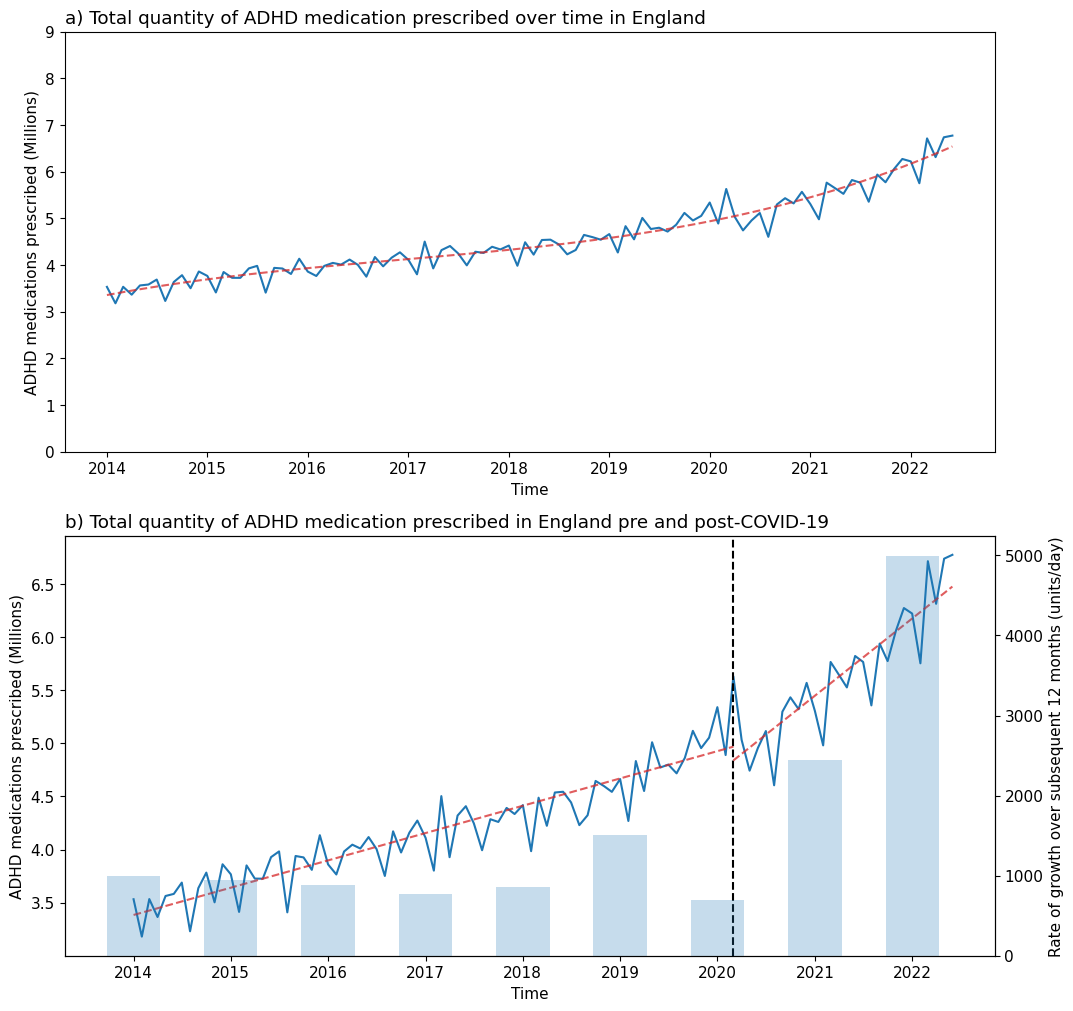

In [1]:
import pandas as pd
import re
import requests
import warnings
import urllib.parse
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import datetime
import numpy as np
import matplotlib.dates as mdates
import matplotlib

font = {'family' : 'normal',
        'size'   : 11}

matplotlib.rc('font', **font)

base_endpoint = 'https://opendata.nhsbsa.net/api/3/action/'
package_list_method = 'package_list'     # List of data-sets in the portal
package_show_method = 'package_show?id=' # List all resources of a data-set
action_method = 'datastore_search_sql?'  # SQL action method
adhd = ['0404000L0','0404000M0','0404000U0','0404000S0','0404000V0',]

## Number of each ADHD medication distributed per month

# Function requests sum(cost) and sum(quantity) data for a given year/month by drug

def get_adhd_data(year,month):
    resource_name = "EPD_"+year+month
    single_month_query = "SELECT chemical_substance_bnf_descr,sum(TOTAL_QUANTITY) AS count,sum(ACTUAL_COST) AS cost " \
                     f"FROM `{resource_name}` " \
                     f"WHERE bnf_chemical_substance IN ('{adhd[0]}','{adhd[1]}','{adhd[2]}','{adhd[3]}','{adhd[4]}') " \
                     f"GROUP BY chemical_substance_bnf_descr "
    
    single_month_api_call = f"{base_endpoint}" \
                        f"{action_method}" \
                        "resource_id=" \
                        f"{resource_name}" \
                        "&" \
                        "sql=" \
                        f"{urllib.parse.quote(single_month_query)}"
    
    single_month_response = requests.get(single_month_api_call).json()
    
    df = pd.json_normalize(single_month_response['result']['result']['records'])
    
    df['year'] = year
    df['month'] = month
    
    #print(f"{resource_name} done!")
    
    return df

# Iterate through all valid year/month combinations, calling the data function for each and 
# concatenating all results

results = '.'

years = ['2014','2015','2016','2017','2018','2019','2020','2021','2022']

months = ['01','02','03','04','05','06','07','08','09','10','11','12']

for year in years:
    for month in months:
        if year == '2022' and month in ['07','08','09','10','11','12']:
            pass
        else:
            if type(results) == str:
                results = get_adhd_data(year,month)
            else:
                results = pd.concat([results,get_adhd_data(year,month)],ignore_index=True)

results["price_per_unit"] = results['cost']/results['count']
results.to_csv("over_time_results.csv")

# Transform data into matrices for plotting, separating by drug

labels = []
counts = []
costs = []
datetimes = []

for value in results['chemical_substance_bnf_descr'].unique():
    subset = results.loc[(results['chemical_substance_bnf_descr'] == value)]
    dates = pd.to_datetime(subset[['year', 'month']].assign(DAY=1))
    datetimes.append(dates)
    labels.append(value)
    counts.append(subset['count'].tolist())
    costs.append(subset['cost'].tolist())

# Plot prescriptions over time for each drug

plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
for i in range(len(labels)):
    plt.plot(datetimes[i],[y/1000000 for y in counts[i]],label = labels[i])

#plt.axvline(x=datetime.date(2020,3,1),color='black',ls='--') 
plt.xlabel('Time')
plt.ylabel('Total Prescribed/Month (Millions)')
plt.title("a) Quantity of drug prescribed per month, by drug",loc="left")
plt.legend()

# Plot cost over time for each drug

plt.subplot(2,2,3)
for i in range(len(labels)):
    plt.plot(datetimes[i],[j/1000000 for j in costs[i]],label = labels[i])

#plt.axvline(x=datetime.date(2020,3,1),color='black',ls='--') 
plt.xlabel('Time')
plt.ylabel('Total Monthly Cost (Million £)')
plt.ylim(bottom=0)
plt.title("b) Total monthly cost of drug over time",loc="left")

# Plot price over time for each drug

plt.subplot(2,2,4)
for i in range(len(labels)):
    plt.plot(datetimes[i],[z/y for y,z in zip(counts[i],costs[i])],label = labels[i])

#plt.axvline(x=datetime.date(2020,3,1),color='black',ls='--') 
plt.xlabel('Time')
plt.ylabel('Price per Unit (£)')
plt.ylim(bottom=0)
plt.title("c) Price per unit of drug over time",loc="left")
plt.savefig("Figures/monthly_pricing")
plt.show()

# Add data where is missing

while len(counts[4]) < 102:
    counts[4].insert(0,0)

# Plot prescriptions over time for sum of all drugs
  
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(datetimes[0],[sum(x)/1000000 for x in zip(*counts)])

plt.xlabel('Time')
plt.ylabel('ADHD medications prescribed (Millions)')

# Plot regression, n=3 (cubic fit)

x = mdates.date2num(datetimes[0])
y = [sum(x)/1000000 for x in zip(*counts)]
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

plt.plot(x, p(x), linestyle="--",alpha=0.75,color="tab:red")
plt.ylim(bottom=0,top=9)
plt.title("a) Total quantity of ADHD medication prescribed over time in England",loc="left")
#plt.savefig('Figures/prescription_trend')
#plt.show()

# Plot prescriptions over time with vline for start of COVID-19

#plt.figure(figsize=(12,6))
plt.subplot(2,1,2)
plt.plot(datetimes[0],[sum(x)/1000000 for x in zip(*counts)])
plt.axvline(x=datetime.date(2020,3,1),ls='--',color='black')
plt.xlabel('Time')
plt.ylabel('ADHD medications prescribed (Millions)')

# Plot Linear Regressions pre and post COVID-19

nomial = 1

x1 = mdates.date2num(datetimes[0][:75])
y1 = [sum(x) for x in zip(*counts)][:75]
z1 = np.polyfit(x1, y1, nomial)
p1 = np.poly1d(z1)

x2 = mdates.date2num(datetimes[0][74:])
y2 = [sum(x) for x in zip(*counts)][74:]
z2 = np.polyfit(x2, y2, nomial)
p2 = np.poly1d(z2)

years_values = np.zeros(9)

# Linear regression for each year

for i in range(1,10):
    
    temp_values = [sum(x) for x in zip(*counts)]
    subset = temp_values[(i-1)*12:(i)*12]

    x = mdates.date2num(datetimes[0][(i-1)*12:(i)*12])
    z = np.polyfit(x, subset, 1)
    p = np.poly1d(z)
    print(z[0])
    years_values[i-1] = z[0]
    
print(f"Coefficient pre-COVID-19: {round(z1[0],1)}")
print(f"Coefficient post-COVID-19: {round(z2[0],1)}")

date_2025 = mdates.date2num(datetime.datetime(2025,1,1))
value_2025 = p2(date_2025)
value_2025_old = p1(date_2025)
print(f"Projected quantity/month in 2025: {int(value_2025)}")
print(f"Projected quantity/month in 2025 (old model): {int(value_2025_old)}")
# Plot 

plt.plot(x1, p1(x1)/1000000, linestyle="--",alpha=0.75,color="tab:red")
plt.plot(x2, p2(x2)/1000000, linestyle="--",alpha=0.75,color="tab:red")

years_positions = datetimes[0][::12]

ax2 = plt.twinx()
ax2.bar(years_positions,years_values,width=200,alpha=0.25)
plt.title("b) Total quantity of ADHD medication prescribed in England pre and post-COVID-19",loc="left")
ax2.set_ylabel("Rate of growth over subsequent 12 months (units/day)")
plt.savefig('Figures/prescription_covid')
plt.show()